First, let's load the libraries.

In [1]:
from torchvision import transforms
from matplotlib import pyplot as plt
import torchvision.datasets as dsets
import torch
import torch.nn as nn
import torch.optim as optim

Next, let's create simple neural network with one hidden layer.

In [2]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

Next, load the data and the model.

In [5]:
test_data = dsets.MNIST(root="./data", train=False, transform=transforms.ToTensor(), download=True)
image = test_data[2][0].view(-1, 28 * 28)
label = test_data[2][1]

net = torch.load("mnist_linear.pt")

Make one forward pass, backprop, and collect the signs.

In [6]:
delta = torch.zeros_like(image, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

logit = net(image + delta)
loss = -nn.CrossEntropyLoss()(logit, torch.LongTensor([label]))

opt.zero_grad()
loss.backward()
opt.step()

sign = torch.sign(delta.data)
labels = list(range(10))
logits = [[] for _ in labels]
epsilons = [a / 250 for a in range(25)]
imgs = []

Take some steps in the direction of the gradient.

In [7]:
for epsilon in epsilons:
    logit = net(image + epsilon * sign)
    imgs.append((image + epsilon * sign, logit.max(dim=1)))

    for i, label in enumerate(labels):
        logits[i].append(logit[0][label].item())

Plot the results.

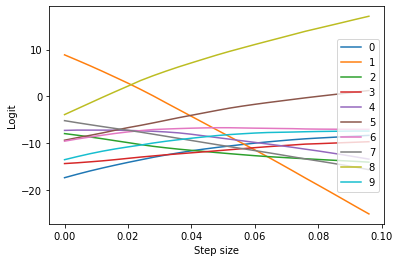

<Figure size 432x288 with 0 Axes>

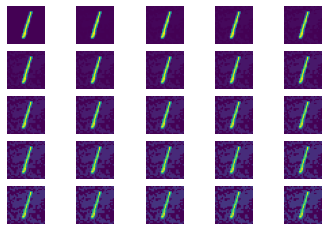

In [8]:
for label, logit in zip(labels, logits):
    plt.plot(epsilons, logit, label=str(label))

plt.legend()
plt.xlabel("Step size")
plt.ylabel("Logit")

plt.show()
#plt.savefig("steps_vs_logits.png", transparent=True)

plt.clf()

f, ax = plt.subplots(5, 5)

for i in range(5):
    for j in range(5):
        img, label = imgs[i * 5 + j]
        ax[i][j].imshow(img.reshape(28, 28))

        ax[i][j].axis("off")

plt.show()
#plt.savefig("adversarial_examples.png", transparent=True)